In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3

In [2]:
#create function to run SQL queries/commands
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

In [3]:
#create run command c function
#indent code below with
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
#create show tables function
#using triple-quoted string for multi-line string in SQL
#See 2.4.1. String and Bytes literals
#https://docs.python.org/3/reference/lexical_analysis.html#string-literals
#Single quotes with line break "\" can be used instead of triple quotes.

def show_tables():
    q= '''
    SELECT 
        name,
        type 
    FROM sqlite_master 
    WHERE type IN ("table","view")'''
    return run_query(q)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [6]:
#Query USA track sales by genre
#uts is USA track sales

q3='''
WITH uts AS
  (
   SELECT il.* 
   FROM invoice_line il
   INNER JOIN invoice i ON il.invoice_id=i.invoice_id
   INNER JOIN customer c ON i.customer_id=c.customer_id
   WHERE c.country="USA"
  )
SELECT
   g.name genre,
   COUNT(uts.invoice_line_id) tracks_sold,
   CAST(COUNT(uts.invoice_line_id) AS float)/(SELECT COUNT(*) FROM uts) pct_sold
FROM uts
INNER JOIN track t ON t.track_id=uts.track_id
INNER JOIN genre g ON g.genre_id=t.genre_id
GROUP BY 1
ORDER BY 2
   '''
run_query(q3)

,genre,tracks_sold,pct_sold
0,TV Shows,1,0.000951
1,Soundtrack,2,0.001903
2,Heavy Metal,3,0.002854
3,Classical,4,0.003806
4,Electronica/Dance,5,0.004757
5,Reggae,6,0.005709
6,Easy Listening,13,0.012369
7,Jazz,14,0.013321
8,Hip Hop/Rap,20,0.019029
9,Latin,22,0.020932


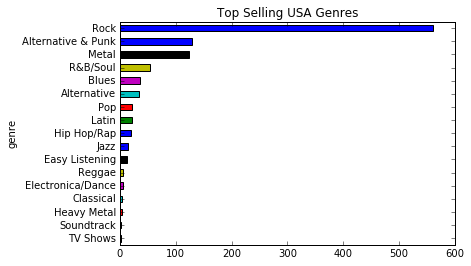

In [7]:
#WITH query produces 1,053 rows from invoice_line table
#To run this cell independently, 

us_track_sales=run_query(q3)
us_track_sales.set_index("genre",inplace=True,drop=True)
us_track_sales["tracks_sold"].plot.barh(title="Top Selling USA Genres")

plt.show()

Artist Recommendations based on Genre Sales:
    
    *Punk, Blues, and Pop Genres sold more than Hip-Hop
    *Based on genre sales, pick the following artists:
        1) Punk - Red Tone
        2) Blues - Slim Jim Bites
        3) Pop - Meteor and the Girls

In [8]:
#Total sales by rep

q4='''
WITH rep AS
   (SELECT *
    FROM employee e
    INNER JOIN customer c ON c.support_rep_id=e.employee_id
   )
SELECT
  rep.first_name || " " || rep.last_name rep_name,
  rep.hire_date,
  SUM(i.total) total_sales
  FROM rep
INNER JOIN invoice i ON i.customer_id=rep.customer_id
GROUP by rep_name
ORDER BY hire_date
    '''
run_query(q4)  

,rep_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


In [9]:
# It is possible that Margaret and Steve's lower sales totals are due
# to later hire dates.
# There is a data quality issue.  Invoice dates start in January 2017 and
# include ALL reps, even though none were hired before April 2017.

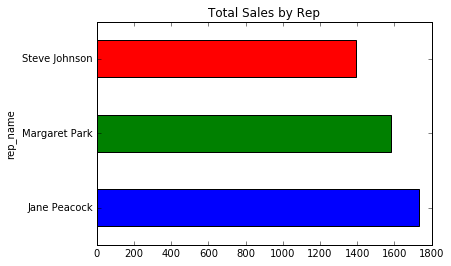

In [10]:
q4='''
WITH rep AS
   (SELECT *
    FROM employee e
    INNER JOIN customer c ON c.support_rep_id=e.employee_id
   )
SELECT
  rep.first_name || " " || rep.last_name rep_name,
  rep.hire_date,
  SUM(i.total) total_sales
  FROM rep
INNER JOIN invoice i ON i.customer_id=rep.customer_id
GROUP by rep_name
ORDER BY hire_date
    '''

q4=run_query(q4)
q4.set_index("rep_name",inplace=True,drop=True)
q4["total_sales"].plot.barh(title="Total Sales by Rep")

plt.show()

In [11]:
#Example of one customer country
one_cust_country_ex='''
SELECT * from customer WHERE country = "Norway"
'''
run_query(one_cust_country_ex)

,customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
0,4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4


          country  customers  total_sales  average_order  cust_avg_value
0             USA         13      1040.49       7.942672       80.037692
1          Canada          8       535.59       7.047237       66.948750
2          Brazil          5       427.68       7.011148       85.536000
3          France          5       389.07       7.781400       77.814000
4         Germany          4       334.62       8.161463       83.655000
5  Czech Republic          2       273.24       9.108000      136.620000
6  United Kingdom          3       245.52       8.768571       81.840000
7        Portugal          2       185.13       6.383793       92.565000
8           India          2       183.15       8.721429       91.575000
9           Other         15      1094.94       7.448571       72.996000


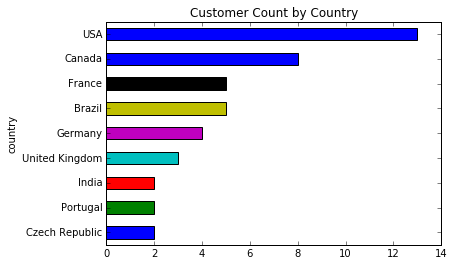

In [37]:
q5='''
WITH country_or_other AS
  (
   SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )
SELECT
  country,
  customers,
  total_sales,
  average_order,
  cust_avg_value
FROM 
    (
     SELECT
        country,
        COUNT(DISTINCT customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price)/COUNT(DISTINCT invoice_id) average_order,
        SUM(unit_price)/COUNT(DISTINCT customer_id) cust_avg_value,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END as sort
     FROM country_or_other
     GROUP BY country
     ORDER BY sort, total_sales DESC
     )
  '''
print(run_query(q5))


#Visualize country sales research results:
#First, save the query to q5 dataframe
q5=run_query(q5)
#Set index to Country;  drop numerical index
q5.set_index("country",inplace=True,drop=True)
# drop Other row
q5.drop("Other",axis=0,inplace=True)

#Print sorted customer counts
q5.sort_values(by="customers",inplace=True,ascending=True)
q5["customers"].plot.barh(title="Customer Count by Country")
plt.show()

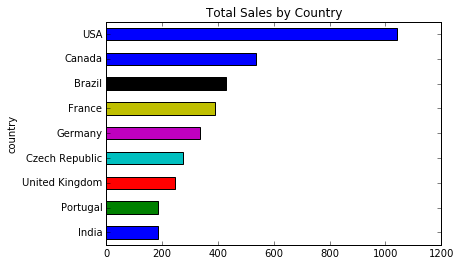

In [42]:
#Print sorted country total_sales
q5.sort_values(by="total_sales",inplace=True,ascending=True)
q5["total_sales"].plot.barh(title="Total Sales by Country")
plt.show()

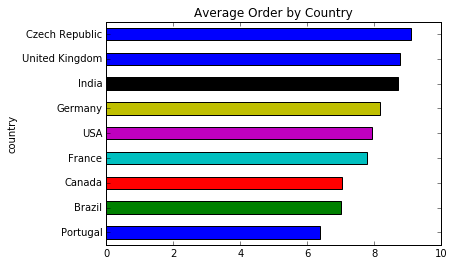

In [43]:
#Print sorted country average_order
q5.sort_values(by="average_order",inplace=True,ascending=True)
q5["average_order"].plot.barh(title="Average Order by Country")
plt.show()

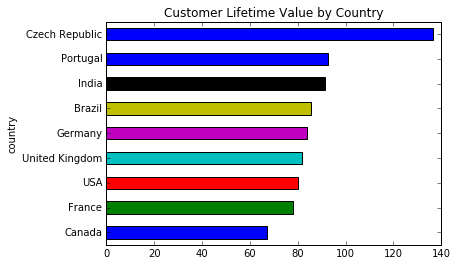

In [45]:
#Print sorted country cust_avg_value
q5.sort_values(by="cust_avg_value",inplace=True,ascending=True)
q5["cust_avg_value"].plot.barh(title="Customer Lifetime Value by Country")
plt.show()

In [46]:
#Recommendations to Marketing - Countries with Growth Potential
#Focus on Czech Republic, Portugal, and India.
#These countries currently have only 2 customers each but
#their customers have the highest lifetime value.
#Test campaign Portugal, which has the smallest order size but
#repeat business giving them the 2nd hightest lifetime value


In [62]:
q7test='''
SELECT
  il.invoice_id,
  a.album_id,
  a.title,
  t.track_id,
  t.name
  
FROM invoice_line il
INNER JOIN track t ON t.track_id=il.track_id
INNER JOIN album a ON a.album_id=t.album_id
WHERE il.invoice_id IN(1,3)
'''
run_query(q7test)

,invoice_id,album_id,title,track_id,name
0,1,91,Use Your Illusion I,1158,Right Next Door to Hell
1,1,91,Use Your Illusion I,1159,Dust N' Bones
2,1,91,Use Your Illusion I,1160,Live and Let Die
3,1,91,Use Your Illusion I,1161,Don't Cry (Original)
4,1,91,Use Your Illusion I,1162,Perfect Crime
5,1,91,Use Your Illusion I,1163,You Ain't the First
6,1,91,Use Your Illusion I,1164,Bad Obsession
7,1,91,Use Your Illusion I,1165,Back off Bitch
8,1,91,Use Your Illusion I,1166,Double Talkin' Jive
9,1,91,Use Your Illusion I,1167,November Rain


In [86]:
table1='''
SELECT
  il.invoice_id,
  t.track_id
FROM invoice_line il
INNER JOIN track t ON t.track_id=il.track_id
WHERE il.invoice_id IN(1,3)
'''
print("table1")
run_query(table1)

table1


,invoice_id,track_id
0,1,1158
1,1,1159
2,1,1160
3,1,1161
4,1,1162
5,1,1163
6,1,1164
7,1,1165
8,1,1166
9,1,1167


In [87]:
table2='''
SELECT
  a.album_id,
  t.track_id
FROM track t
INNER JOIN album a ON a.album_id=t.album_id
WHERE a.album_id IN(91,203)
'''
print("table2")
run_query(table2)

table2


,album_id,track_id
0,91,1158
1,91,1159
2,91,1160
3,91,1161
4,91,1162
5,91,1163
6,91,1164
7,91,1165
8,91,1166
9,91,1167


In [108]:
q7='''
WITH table1 AS
  (
   SELECT
     il.invoice_id,
     t.track_id
   FROM invoice_line il
   INNER JOIN track t ON t.track_id=il.track_id
   WHERE il.invoice_id IN(1,3)
  ),
      table2 AS
  (
   SELECT
     a.album_id,
     t.track_id
   FROM track t
   INNER JOIN album a ON a.album_id=t.album_id
   WHERE a.album_id IN(91,203)
  )
SELECT
   table1.invoice_id,
   MIN(table1.track_id) first_track,
   CASE WHEN(
            SELECT track_id FROM table1
            EXCEPT
            SELECT track_id FROM table2
            ) IS NULL 
            AND
            (
            SELECT track_id FROM table2
            EXCEPT
            SELECT track_id FROM table1
             ) IS NULL
    THEN "Album"
    ELSE "NotAlbum"
    END 
    AS Album_Test        
FROM table1
INNER JOIN table2 ON table2.track_id=table1.track_id
'''
run_query(q7)

,invoice_id,MIN(table1.track_id),Album_Test
0,1,1158,NotAlbum
